# ID3决策树  西瓜数据集2.0案例

项目概述：  
$\quad$根据以下6个特征，将西瓜分成两类：好瓜和坏瓜  
特征：  
$\quad$1.西瓜的颜色  
$\quad$2.西瓜的根卷曲程度  
$\quad$3.敲打西瓜发出的声音  
$\quad$4.西瓜表面的纹理  
$\quad$5.西瓜脐部凹陷情况  
$\quad$6.抚摸西瓜时的触感  

开发流程：  
$\quad$收集数据集：可以使用任何方法.  
$\quad$准备数据：树构造算法（这里使用ID3算法，因此数值型数据必须离散化。）  
$\quad$分析数据：可以使用任何方法，构造书完成之后，我们可以将树画出来。  
$\quad$训练算法：构造树结构。  
$\quad$测试算法：使用习得的决策树执行分类。  
$\quad$使用算法：此步骤可以适用于任何监督学习任务，而使用决策树可以更好地理解数据的内在含义。  

In [132]:
import math
import operator
import copy
import numpy as np

### 一、收集数据：利用createDataSet（）函数输入数据

In [133]:
def createDataSet():
    # dataSet中最后一列记录的是类别，其余列记录的是特征值
    dataSet = [
        ['青绿','蜷缩','浊响','清晰','凹陷','硬滑','是'],
        ['乌黑','蜷缩','沉闷','清晰','凹陷','硬滑','是'],
        ['乌黑','蜷缩','浊响','清晰','凹陷','硬滑','是'],
        ['青绿','蜷缩','沉闷','清晰','凹陷','硬滑','是'],
        ['浅白','蜷缩','浊响','清晰','凹陷','硬滑','是'],
        ['青绿','稍蜷','浊响','清晰','稍凹','软粘','是'],
        ['乌黑','稍蜷','浊响','稍糊','稍凹','软粘','是'],
        ['乌黑','稍蜷','浊响','清晰','稍凹','硬滑','是'],
        ['乌黑','稍蜷','沉闷','稍糊','稍凹','硬滑','否'],
        ['青绿','硬挺','清脆','清晰','平坦','软粘','否'],
        ['浅白','硬挺','清脆','模糊','平坦','硬滑','否'],
        ['浅白','蜷缩','浊响','模糊','平坦','软粘','否'],
        ['青绿','稍蜷','浊响','稍糊','凹陷','硬滑','否'],
        ['浅白','稍蜷','沉闷','稍糊','凹陷','硬滑','否'],
        ['乌黑','稍蜷','浊响','清晰','稍凹','软粘','否'],
        ['浅白','蜷缩','浊响','模糊','平坦','硬滑','否'],
        ['青绿','蜷缩','沉闷','稍糊','稍凹','硬滑','否']
    ]
    
    # label中记录的是特征的名称
    labels = ['色泽','根蒂','敲声','纹理','脐部','触感']
    
    classList = [example[-1] for example in dataSet]
    inidata = copy.deepcopy(dataSet)
    inilabels = copy.deepcopy(labels)
    
    return dataSet, labels, classList, inidata, inilabels

### 二、准备数据
$\quad$由于我们输入的数据本身就是离散化数据，所以这一步就省略了。

### 三、分析数据
使用信息增益的方法：  
$信息熵：Ent(D) = - \sum_{k=1}^{|Y|}p_k log_2 p_k$  
$信息增益：Gain(D,a) = Ent(D) - \sum_{v=1}^{V} \frac{|D^v|}{|D|} Ent(D^v)$

### 四、算法分析
1.对于每一个结点，首先会将其视为叶节点，计算它的信息熵，所以把“结点计算信息熵”写做一个函数。   
2.对于每一个节点都有一个数据集，该数据集是根据其“特征”父节点下的属性划分出来的，所以把“数据集划分”写做一个函数。  
3.对每一个结点都会选择最优特征，对每一个“特征”都会计算其信息增益，所以把“计算信息增益，并返回最优特征”写做一个函数。  
4.停止划分结点的三种情况：a）所有的类标签完全相同，则直接返回该类标签；b）使用完了所有特征，仍然不能将数据集划分成仅包含唯一类别的分组，那么出现相同label多的一类，作为结果；c）如果该结点为空集，则将其设为叶子结点，节点类型为其父节点中类别最多的类。

#### 1.计算给定数据集的信息熵的函数
由于每需要确定一个节点，就需要计算一次该节点的信息熵，于是我们将它写成函数，方便调用。

In [134]:
def calcShannonEnt(dataSet):
    # 计算参与训练的数据量，即训练集中共有多少条数据;用作信息熵概率 p 的分母
    numEntries = len(dataSet)
    # 计算每个分类标签label在当前节点出现的次数，即每个类别在当前节点下别分别出现多少次，用作信息熵概率 p 的分子
    labelCounts = {}
    
    # 每次读入一条样本数据
    for featVec in dataSet:
        # 将当前实例的类别存储，即每一行数据的最后一个数据代表的是类别
        currentLabel = featVec[-1]
        
        #为所有分类创建字典，每个键值对都记录了当前类别出现的次数
        if currentLabel not in labelCounts:
            labelCounts[currentLabel] = 0
        
        labelCounts[currentLabel] += 1
        
    # 使用循环方法，依次求出公式求和部分每个类别所占的比例及相应的计算
    shannonEnt = 0 #记录信息熵的值
    for key in labelCounts:
        # 算出该类别在该节点数据集中所占的比例
        prob = labelCounts[key] / numEntries
        shannonEnt -= prob * math.log(prob, 2)
    
    return shannonEnt

上述巧妙的将信息熵的公式写为：$Ent(D) = 0 - p_1 log_2 p_1 - p_2 log_2 p_2$

#### 2.按照给定的特征划分子数据集
通过遍历dataSet数据集，求出去除父节点特征后的其余特征组合成的数据集。

In [135]:
'''
1.dataSet为该节点的父节点使用的数据集
2.retDataSet为某特征下去除特定属性后其余的数据
3.value为某个特征下的其中一个属性
4.index为当前操作的是哪一个特征
'''
def splitDataSet(dataSet, index, value):
    # 存储划分好的数据集
    retDataSet = []   
    for featVec in dataSet:
        if featVec[index] == value:
            reducedFeatVec = featVec[:index]
            reducedFeatVec.extend(featVec[index+1:])
            retDataSet.append(reducedFeatVec)
    
    return retDataSet

$\quad \quad$以特征“色泽”下的属性“乌黑”为例：

In [136]:
dataSet, _ ,_,_,_= createDataSet()

In [137]:
splitDataSet(dataSet, 0, "乌黑")

[['蜷缩', '沉闷', '清晰', '凹陷', '硬滑', '是'],
 ['蜷缩', '浊响', '清晰', '凹陷', '硬滑', '是'],
 ['稍蜷', '浊响', '稍糊', '稍凹', '软粘', '是'],
 ['稍蜷', '浊响', '清晰', '稍凹', '硬滑', '是'],
 ['稍蜷', '沉闷', '稍糊', '稍凹', '硬滑', '否'],
 ['稍蜷', '浊响', '清晰', '稍凹', '软粘', '否']]

#### 3.选择最好的特征划分数据集
目的是找到用来划分该节点的特征。

In [138]:
def chooseBestFeatureToSplit(dataSet):
    # 求该数据集中共有多少特征（由于最后一列为label标签，所以减1）
    numFeatures = len(dataSet[0]) - 1
    # 将该结点视为叶子节点，计算该节点的信息熵
    baseEntropy = calcShannonEnt(dataSet)
    # 初始化最优信息增益值，和最优的特征索引
    bestInfoGain, bestFeature = 0, -1
    
    # 依次遍历每一个特征，计算其信息增益
    # 当前数据集中有几列就说明有几个特征
    for i in range(numFeatures):
        # 将数据集中每一个特征下的所有属性拿出来生成一个列表
        featList = [example[i] for example in dataSet]
        # 使用集合对列表进行去重，获得去重后的集合，即：此时集合中每个属性只出现一次
        uniqueVals = set(featList)
        # 创建一个临时信息熵
        newEntropy = 0
        
        # 依次遍历该特征下的所有属性
        for value in uniqueVals:
            # 依据每一个属性划分数据集
            subDataSet = splitDataSet(dataSet,i,value) # 详情见splitDataSet函数
            # 计算该属性包含的数据占该特征包含数据的比例
            pro = len(subDataSet) / len(dataSet) 
            # 计算每个属性结点的信息熵，并乘以相应的权重，再求他们的和，即为该特征节点的信息熵
            newEntropy += pro * calcShannonEnt(subDataSet) 
        
        # 计算信息增益
        infoGain = baseEntropy - newEntropy
        
        # 比较所有特征中的信息增益，返回最好特征划分的索引值
        if (infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i 
    
    # 返回最优的特征索引
    return bestFeature

#### 4.返回该节点数据集中类别出现次数最多的类别

In [139]:
'''classList:为标签列的列表形式'''
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1 # classCount以字典形式记录每个类别出现的次数
        
    # 倒叙排列classCount得到一个字典集合，然后取出第一个就是结果（好瓜/坏瓜），即出现次数最多的结果
    # sortedClassCount的形式是[(),(),(),...],每个键值对变为元组并以列表形式返回
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1),reverse=True)
    
    return sortedClassCount[0][0] # 返回的是出现类别次数最多的“类别”

例：

In [140]:
a ={'a':5,'b':8,'c':10}
a.items()

dict_items([('a', 5), ('b', 8), ('c', 10)])

operator.itemgetter(1)：表示按元组中 1 号位索引位置进行排序，即：按字典中value值进行排序，也就是按照每个类别出现的次数排序。

#### 5.训练算法：构造树的数据结构

In [141]:
def createTree(dataSet, labels,FutherClassList,inidata,inilabels):
    
    # 如果该结点为空集，则将其设为叶子结点，节点类型为其父节点中类别最多的类。
    if len(dataSet) == 0:
        return majorityCnt(FutherClassList)
    
    # classList中记录了该节点数据中“类别”一列，保存为列表形式
    classList = [example[-1] for example in dataSet] 
    
    # 第一个停止条件：所有的类标签完全相同，则直接返回该类标签
    # 如果数据集到最后一列的第一个值出现的次数=整个集合的数量，也就说只有一个类别，直接返回结果即可
    if classList.count(classList[0]) == len(classList): # count()函数是统计括号中的值在list中出现的次数
        return classList[0]
    
    # 第二个停止条件：使用完了所有特征，仍然不能将数据集划分成仅包含唯一类别的分组
    # 如果最后只剩一个特征，那么出现相同label多的一类，作为结果
    if len(dataSet[0]) == 1: # 所有的特征都用完了，只剩下最后的标签列了
        return majorityCnt(classList)
    
        
    # 选择最优的特征
    bestFeat = chooseBestFeatureToSplit(dataSet)# 返回的是最优特征的索引
    # 获取最优特征
    bestFeatLabel = labels[bestFeat]
    # 初始化决策树
    myTree = {bestFeatLabel:{}}
    #将使用过的特征数据删除
    del(labels[bestFeat])
    # 在数据集中去除最优特征列，然后用最优特征的分支继续生成决策树
    indexF = inilabels.index(bestFeatLabel)
    featValues = [example[indexF] for example in inidata]
    uniqueVals = set(featValues)
    # 遍历该特征下每个属性节点，继续生成决策树
    for value in uniqueVals:
        # 求出剩余的可用的特征
        subLabels = labels[:]
        
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet,bestFeat,value),subLabels,classList,inidata,inilabels)
    
    return myTree

构建好的决策树文本输出格式如下：

In [142]:
dataSet,labels, classList, inidata, inilabels = createDataSet()
myTree = createTree(dataSet, labels,classList,inidata,inilabels)

In [143]:
print(myTree)

{'纹理': {'稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}, '清晰': {'根蒂': {'稍蜷': {'色泽': {'浅白': '是', '乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}, '青绿': '是'}}, '硬挺': '否', '蜷缩': '是'}}, '模糊': '否'}}


#### 6.最终生成的决策树图形形式如下：

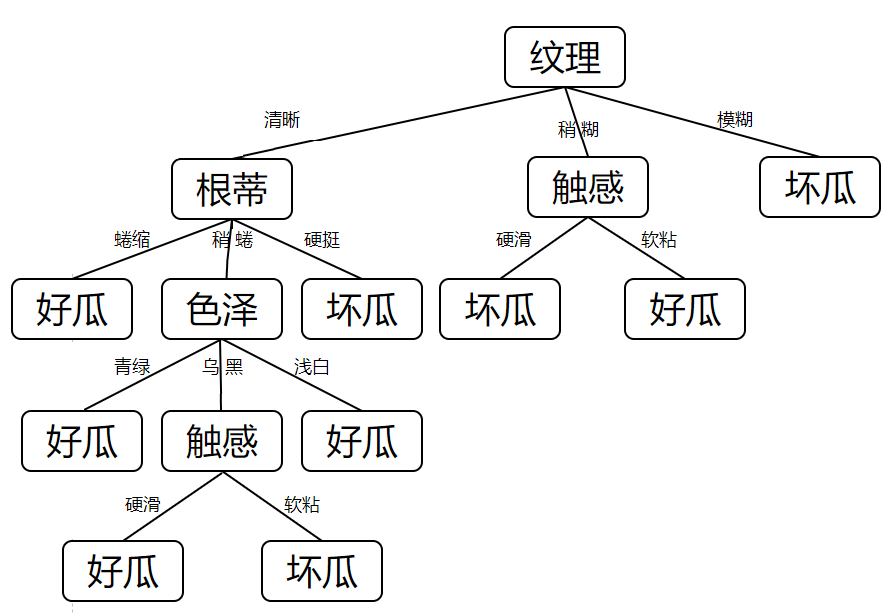

#### 7.测试算法：使用决策树执行分类
inputTree：是构建好的决策树模型  
featLabels：是特征的名称  
testVec：测试输入的数据,是对应featLabels中特征下的属性名称

In [144]:
def classify(inputTree, featLabels, testVec):
    # 拿到当前树模型的根节点
    firstStr = list(inputTree.keys())[0]
    # 拿到当前树模型去除根节点后的分支树
    secondDict = inputTree[firstStr]
    # 返回根节点特征在特征列表中的索引
    featIndex = featLabels.index(firstStr)
    # 在测试集中找到该特征下的属性
    key = testVec[featIndex]
    # 根据该属性找到下一层的特征节点
    valueOfFeat = secondDict[key]
    # 输出查看类别判定过程：根据特征，选择属性
    print('+++',firstStr,'xxx',secondDict,'---',key,'>>>',valueOfFeat)
    
    # 判断分支是否结束;判断valueOfFeat是否是dict类型
    # 若是dict类型，则表示该节点非叶子节点，继续递归；
    # 若不是dict类型，则表示该节点是叶子节点，已经分类完成，可以打印类别
    if isinstance(valueOfFeat,dict):
        classLabel = classify(valueOfFeat,featLabels,testVec)
    else:
        classLabel= valueOfFeat
    
    return classLabel

此处使用的是训练集中的数据，意在了解决策树的分类过程，实际应用中这里输入的应该是模型没有见过的测试集。

In [145]:
featLabels=['色泽','根蒂','敲声','纹理','脐部','触感']
testVec = ['青绿','蜷缩','沉闷','稍糊','稍凹','硬滑']
classify(myTree,featLabels,testVec)

+++ 纹理 xxx {'稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}, '清晰': {'根蒂': {'稍蜷': {'色泽': {'浅白': '是', '乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}, '青绿': '是'}}, '硬挺': '否', '蜷缩': '是'}}, '模糊': '否'} --- 稍糊 >>> {'触感': {'硬滑': '否', '软粘': '是'}}
+++ 触感 xxx {'硬滑': '否', '软粘': '是'} --- 硬滑 >>> 否


'否'

# C4.5决策树  西瓜数据集2.0案例

C4.5大致思路与ID3相同，唯一的差别是最优特征选择的标准使用的是信息增益率。  
信息增益率选取规则：先从候选划分特征中找出信息增益率高于平均水平的特征，再从中选择增益率最高的。

In [146]:
def C45_chooseBestFeatureToSplit(dataSet):

    # 求该数据集中共有多少特征（由于最后一列为label标签，所以减1）
    numFeatures = len(dataSet[0]) - 1
    # 将该结点视为叶子节点，计算该节点的信息熵
    baseEntropy = calcShannonEnt(dataSet)
    # 初始化最优增益值率，和最优的特征索引
    bestInfoGainRatio, bestFeature = 0, -1
    
    # 记录每个特征的信息增益，以列表形式存储
    eachEntropy = []
    # 记录每个特征下的属性数据集占特征数据集的比例
    eachFeaturesPro = []
    # 依次遍历每一个特征，计算其信息增益
    # 当前数据集中有几列就说明有几个特征
    for i in range(numFeatures):
        # 将数据集中每一个特征下的所有属性拿出来生成一个列表
        featList = [example[i] for example in dataSet]
        # 使用集合对列表进行去重，获得去重后的集合，即：此时集合中每个属性只出现一次
        uniqueVals = set(featList)
        # 创建一个临时信息熵
        newEntropy = 0
        # 记录该特征下的属性数据集占特征数据集的比例
        eachpro = []
        
        # 依次遍历该特征下的所有属性
        for value in uniqueVals:
            # 依据每一个属性划分数据集
            subDataSet = splitDataSet(dataSet,i,value) # 详情见splitDataSet函数
            # 计算该属性包含的数据占该特征包含数据的比例
            pro = len(subDataSet) / len(dataSet) 
            # 计算每个属性结点的信息熵，并乘以相应的权重，再求他们的和，即为该特征节点的信息熵
            newEntropy += pro * calcShannonEnt(subDataSet) 
            # 将该属性数据集数量占特征数据集比例加入到字典
            eachpro += [pro]
        
        eachFeaturesPro.append(eachpro)
        
        # 计算该特征信息增益
        infoGain = baseEntropy - newEntropy
        
        '''1.把每个特征的信息增益保存起来
           2.求所有特征信息增益的平均值
           3.对信息增益大于平均值的特征求增益率
           4.选择增益率最大的特征'''
        
        eachEntropy += [infoGain]
        
    # 对所有特征信息增益取平均值     
    aveEntropy = np.mean(eachEntropy)
    
    # 对信息增益大于平均值的特征求增益率
    for j in range(numFeatures):
        # 之所以有等于号，是因为可能会出现所有值相等的情况，这样平均值也与他们的值相等
        if eachEntropy[j] >= aveEntropy:
            IVa = 0
            for prob in eachFeaturesPro[j]:
                IVa -= prob * math.log(prob, 2)
            
            newGainRatio = eachEntropy[j] / IVa
            
            if newGainRatio >= bestInfoGainRatio:
                bestInfoGainRatio = newGainRatio
                bestFeature = j
    
    # 返回最优的特征索引
    return bestFeature

In [147]:
def C45_createTree(dataSet, labels,FutherClassList,inidata,inilabels):
    
    # 如果该结点为空集，则将其设为叶子结点，节点类型为其父节点中类别最多的类。
    if len(dataSet) == 0:
        return majorityCnt(FutherClassList)
    
    # classList中记录了该节点数据中“类别”一列，保存为列表形式
    classList = [example[-1] for example in dataSet] 
    
    # 第一个停止条件：所有的类标签完全相同，则直接返回该类标签
    # 如果数据集到最后一列的第一个值出现的次数=整个集合的数量，也就说只有一个类别，直接返回结果即可
    if classList.count(classList[0]) == len(classList): # count()函数是统计括号中的值在list中出现的次数
        return classList[0]
    
    # 第二个停止条件：使用完了所有特征，仍然不能将数据集划分成仅包含唯一类别的分组
    # 如果最后只剩一个特征，那么出现相同label多的一类，作为结果
    if len(dataSet[0]) == 1: # 所有的特征都用完了，只剩下最后的标签列了
        return majorityCnt(classList)

    
    # 选择最优的特征
    bestFeat = C45_chooseBestFeatureToSplit(dataSet)# 返回的是最优特征的索引
    # 获取最优特征
    bestFeatLabel = labels[bestFeat]
    # 初始化决策树
    C45_myTree = {bestFeatLabel:{}}
    #将使用过的特征数据删除
    del(labels[bestFeat])
    
    
    # 在数据集中去除最优特征列，然后用最优特征的分支继续生成决策树
    indexF = inilabels.index(bestFeatLabel)
    featValues = [example[indexF] for example in inidata]
    uniqueVals = set(featValues)

    # 遍历该特征下每个属性节点，继续生成决策树
    for value in uniqueVals:
        # 求出剩余的可用的特征
        subLabels = labels[:]
        
        C45_myTree[bestFeatLabel][value] = C45_createTree(splitDataSet(dataSet,bestFeat,value),subLabels,classList,inidata,inilabels)
        # print('myTree',value,myTree)
    
    return C45_myTree

In [148]:
dataSet,labels, classList, inidata, inilabels = createDataSet()
C45_myTree = C45_createTree(dataSet, labels,classList,inidata,inilabels)

In [149]:
print(C45_myTree)

{'纹理': {'稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}, '清晰': {'触感': {'硬滑': '是', '软粘': {'脐部': {'平坦': '否', '稍凹': {'色泽': {'浅白': '是', '乌黑': '否', '青绿': '是'}}, '凹陷': '否'}}}}, '模糊': '否'}}


#### 最终生成的决策树如下：

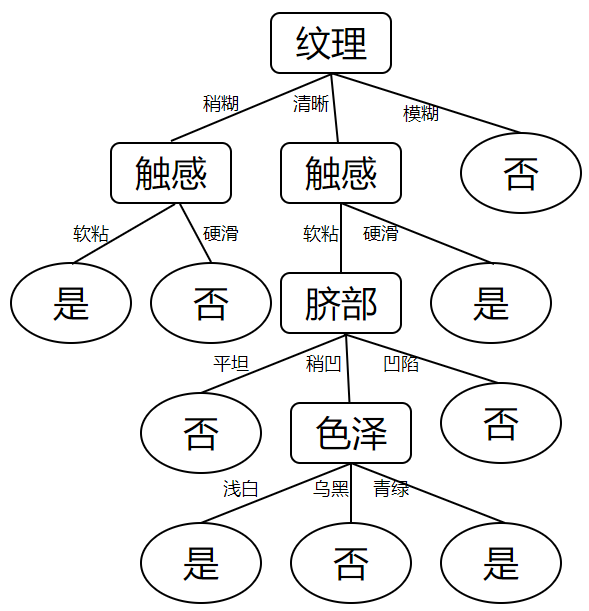

# CART 决策树 西瓜数据集2.0案例
部分函数修改如下。

#### 每一个特征下的属性节点都需要求基尼值

In [150]:
def CART_Gini(dataSet):
    # 计算参与训练的数据量，即训练集中共有多少条数据;
    numEntries = len(dataSet)
    # 计算每个分类标签label在当前节点出现的次数，即每个类别在当前节点下别分别出现多少次，用作信息熵概率 p 的分子
    labelCounts = {}
    
    # 每次读入一条样本数据
    for featVec in dataSet:
        # 将当前实例的类别存储，即每一行数据的最后一个数据代表的是类别
        currentLabel = featVec[-1]
        
        #为所有分类创建字典，每个键值对都记录了当前类别出现的次数
        if currentLabel not in labelCounts:
            labelCounts[currentLabel] = 0
        
        labelCounts[currentLabel] += 1
        
    # 使用循环方法，依次求出公式求和部分每个类别所占的比例及相应的计算
    Gini = 1 #记录基尼值
    for key in labelCounts:
        # 算出该类别在该节点数据集中所占的比例
        prob = labelCounts[key] / numEntries
        Gini -= prob * prob
    
    return Gini

#### 选择最优的特征进行划分数据集

In [163]:
def CART_chooseBestFeatureToSplit(dataSet):
    # 求该数据集中共有多少特征（由于最后一列为label标签，所以减1）
    numFeatures = len(dataSet[0]) - 1
    
    # 将该结点视为叶子节点，计算该节点的信息熵
    # baseEntropy = calcShannonEnt(dataSet)
    
    # 初始化最优基尼指数，和最优的特征索引
    bestGiniIndex, bestFeature = 1, -1
    
    # 依次遍历每一个特征，计算其基尼指数
    # 当前数据集中有几列就说明有几个特征
    for i in range(numFeatures):
        # 将数据集中每一个特征下的所有属性拿出来生成一个列表
        featList = [example[i] for example in dataSet]
        # 使用集合对列表进行去重，获得去重后的集合，即：此时集合中每个属性只出现一次
        uniqueVals = set(featList)
        # 创建一个临时基尼指数
        newGini_index = 0
        
        # 依次遍历该特征下的所有属性
        for value in uniqueVals:
            # 依据每一个属性划分数据集
            subDataSet = splitDataSet(dataSet,i,value) # 详情见splitDataSet函数
            # 计算该属性包含的数据占该特征包含数据的比例
            pro = len(subDataSet) / len(dataSet) 
            # 计算每个属性结点的基尼值，并乘以相应的权重，再求他们的和，即为该特征节点的基尼指数
            newGini_index += pro * CART_Gini(subDataSet) 
        
        # 计算信息增益
        # infoGain = baseEntropy - newEntropy
        
        
        # 比较所有特征中的基尼指数，返回最好特征划分的索引值，注意：基尼指数越小越好
        if (newGini_index < bestGiniIndex):
            bestGiniIndex = newGini_index
            bestFeature = i 
    
    # 返回最优的特征索引
    return bestFeature

#### 创建CART决策树

In [164]:
def CART_createTree(dataSet, labels,FutherClassList,inidata,inilabels):
    
    # 如果该结点为空集，则将其设为叶子结点，节点类型为其父节点中类别最多的类。
    if len(dataSet) == 0:
        return majorityCnt(FutherClassList)
    
    # classList中记录了该节点数据中“类别”一列，保存为列表形式
    classList = [example[-1] for example in dataSet] 
    
    # 第一个停止条件：所有的类标签完全相同，则直接返回该类标签
    # 如果数据集到最后一列的第一个值出现的次数=整个集合的数量，也就说只有一个类别，直接返回结果即可
    if classList.count(classList[0]) == len(classList): # count()函数是统计括号中的值在list中出现的次数
        return classList[0]
    
    # 第二个停止条件：使用完了所有特征，仍然不能将数据集划分成仅包含唯一类别的分组
    # 如果最后只剩一个特征，那么出现相同label多的一类，作为结果
    if len(dataSet[0]) == 1: # 所有的特征都用完了，只剩下最后的标签列了
        return majorityCnt(classList)
    
        
    # 选择最优的特征
    bestFeat = CART_chooseBestFeatureToSplit(dataSet)# 返回的是最优特征的索引
    # 获取最优特征
    bestFeatLabel = labels[bestFeat]
    # 初始化决策树
    CART_myTree = {bestFeatLabel:{}}
    #将使用过的特征数据删除
    del(labels[bestFeat])
    # 在数据集中去除最优特征列，然后用最优特征的分支继续生成决策树
    indexF = inilabels.index(bestFeatLabel)
    featValues = [example[indexF] for example in inidata]
    uniqueVals = set(featValues)
    # 遍历该特征下每个属性节点，继续生成决策树
    for value in uniqueVals:
        # 求出剩余的可用的特征
        subLabels = labels[:]
        
        CART_myTree[bestFeatLabel][value] = CART_createTree(splitDataSet(dataSet,bestFeat,value),subLabels,classList,inidata,inilabels)
    
    return CART_myTree

In [165]:
dataSet,labels, classList, inidata, inilabels = createDataSet()
CART_myTree = CART_createTree(dataSet, labels,classList,inidata,inilabels)

In [166]:
print(CART_myTree)

{'纹理': {'稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}, '清晰': {'根蒂': {'稍蜷': {'色泽': {'浅白': '是', '乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}, '青绿': '是'}}, '硬挺': '否', '蜷缩': '是'}}, '模糊': '否'}}


#### 最终生成的决策树如下：

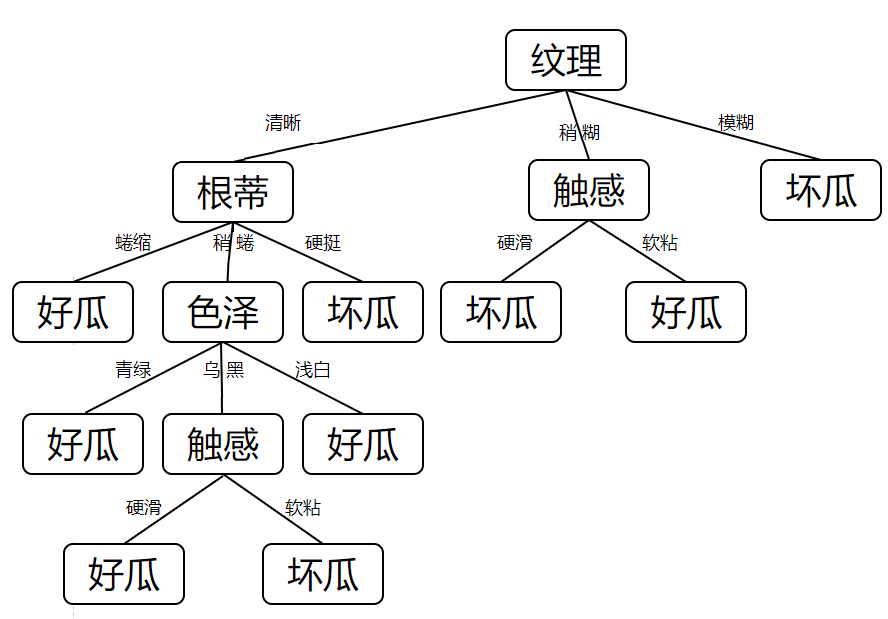